# Dicussion on Overfitting

Today, we'll discuss overfitting. Overfitting can occur when your model has too much complexity, or is too powerful. Then, your model can learn some of the random "noise" in the dataset, which are remnant patterns which are not generalizable. This can happen for any model, for example for polynomails when you have too high of a degree, and neural networks when you have too many neurons.

Below we can see what overfitting may look like with polynomials:

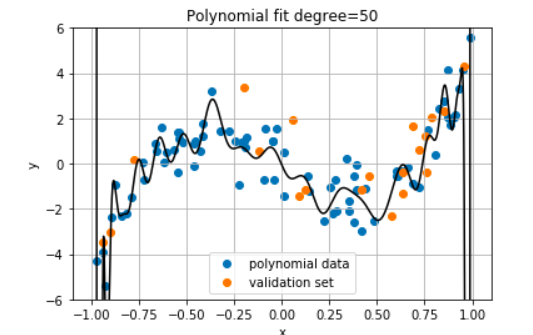

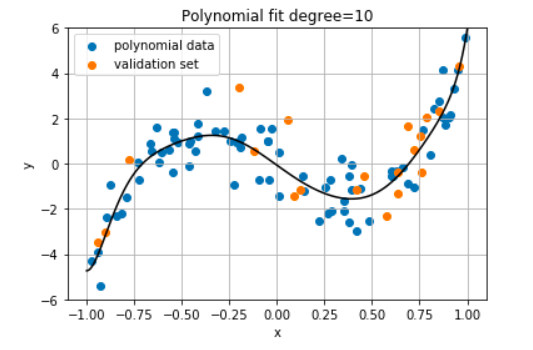

So now that we’ve seen the concept of overfitting on a simple 2 dimensional example, let’s see an example of overfitting in action. We’ll see what overfitting may look like with neural networks. For this, we'll be using the [Beijing Air Quality Dataset](https://github.com/PhilChodrow/PIC16B/blob/master/discussion/PRSA_Data_20130301-20170228.zip?raw=true) that I've extracted from a UC Irvine ML database, and we'll be trying to predict an air quality value using some of the other features.

Let's first mount our Google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


Now, with neural networks, we often want to use the GPU runtime on Colab to speed up training. You can do this by going to Runtime -> Change runtime type, and then choosing GPU for your hardware accelerator.

Now, let's import our libaries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'      # 3 = INFO, WARNING, and ERROR messages are not printed
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["KMP_WARNINGS"] = "FALSE"            # Removes a lot of GPU debug messages that are not needed


And let's load our data. I also do some data cleaning here, such as standardization and encoding.

In [ ]:
path = r'/content/gdrive/MyDrive/PRSA_Data_20130301-20170228/' # use the path to your unzipped data
all_files = glob.glob(path + "/*.csv")

df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)

    dir_one_hot = pd.get_dummies(df.wd, prefix='direction')
    stat_one_hot = pd.get_dummies(df.station, prefix='station')
    df = pd.concat([df, dir_one_hot, stat_one_hot], axis=1)

    df.drop(columns=['No', 'PM10', 'station', 'wd'], inplace=True)

    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True).fillna(0)
train, test = train_test_split(df, test_size=0.2, random_state=1)

# Normalize the data
columns_to_normalize = [i for i in train.columns if ('station' not in i) and ('direction' not in i)]
columns_to_normalize.remove('RAIN')

mean_scaler = preprocessing.StandardScaler()
train[columns_to_normalize] = mean_scaler.fit_transform(train[columns_to_normalize])
test[columns_to_normalize] = mean_scaler.transform(test[columns_to_normalize])

# Separate the label from the rest of the features
y_train = train['PM2.5'].to_numpy(dtype = np.float32).reshape((-1, 1))
y_test = test['PM2.5'].to_numpy(dtype = np.float32).reshape((-1, 1))

x_train = train.drop(columns=['PM2.5']).to_numpy(dtype = np.float32)
x_test = test.drop(columns=['PM2.5']).to_numpy(dtype = np.float32)

print(x_train.shape)
train.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

(336614, 41)


year     month  ...  station_Wanliu  station_Wanshouxigong
330575 -0.562657  1.297733  ...             0.0                    0.0
304607  0.286762  1.297733  ...             0.0                    0.0
190483 -0.562657  1.297733  ...             0.0                    0.0
183891 -0.562657 -1.311797  ...             0.0                    0.0
81918  -0.562657  0.137942  ...             0.0                    0.0
136249  1.136180  0.717837  ...             0.0                    0.0
158372  0.286762 -1.021850  ...             0.0                    0.0
222430 -0.562657  0.137942  ...             0.0                    0.0
223911 -0.562657  0.717837  ...             0.0                    0.0
337405  0.286762  0.427890  ...             0.0                    0.0

[10 rows x 42 columns]

Now let's create our model:

In [ ]:
def create_model(input_size): # keep
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_size,)),
    tf.keras.layers.Dense(units=123, activation='relu'),
    tf.keras.layers.Dense(units=164, activation='relu'),
    tf.keras.layers.Dense(units=123, activation='relu'),
    tf.keras.layers.Dense(units=82, activation='relu'),
    tf.keras.layers.Dense(units=1)
  ])

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=['mse'])
  return model

In [ ]:
nn_regression_model = create_model(x_train.shape[1])
nn_regression_model.summary()     # Can do as supplying input size automatically builds the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 123)               5166      
_________________________________________________________________
dense_1 (Dense)              (None, 164)               20336     
_________________________________________________________________
dense_2 (Dense)              (None, 123)               20295     
_________________________________________________________________
dense_3 (Dense)              (None, 82)                10168     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 83        
Total params: 56,048
Trainable params: 56,048
Non-trainable params: 0
_________________________________________________________________


Now let's fit our model:

In [ ]:
history = nn_regression_model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=2000, validation_split=0.2)

Epoch 1/100
135/135 [==============================] - 2s 8ms/step - loss: 0.2877 - mse: 0.2877 - val_loss: 0.2185 - val_mse: 0.2185
Epoch 2/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1949 - mse: 0.1949 - val_loss: 0.1733 - val_mse: 0.1733
Epoch 3/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1688 - mse: 0.1688 - val_loss: 0.1635 - val_mse: 0.1635
Epoch 4/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1588 - mse: 0.1588 - val_loss: 0.1498 - val_mse: 0.1498
Epoch 5/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1457 - mse: 0.1457 - val_loss: 0.1475 - val_mse: 0.1475
Epoch 6/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1409 - mse: 0.1409 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 7/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1343 - mse: 0.1343 - val_loss: 0.1347 - val_mse: 0.1347
Epoch 8/100
135/135 [==============================] - 1s 6ms/step - 

And plot the loss:

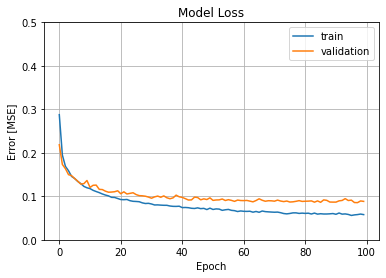

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MSE]')
plt.ylim([0, 0.5])
plt.legend(['train', 'validation'])
plt.grid(True)
plt.show()

Our training loss is always decreasing, which is good. This suggests our model is at least learning the relationships in the training data. However, we see that eventually our validation set accuracy stops decreasing. At this point, the patterns we are learning aren't "generalizable" anymore, we are learning some of the spurious patterns in the training set.

To address this, as in our polynomial examples above, we actually want to give our model less firepower. Let's try to do this below:

In [ ]:
def create_model_dropout(input_size): # keep
  model = tf.keras.Sequential([                  #copy, set stepsize to 0.001, add dropout
    tf.keras.layers.Input(shape=(input_size,)),
    tf.keras.layers.Dense(units=123, activation='relu'),
    tf.keras.layers.Dense(units=164, activation='relu'),
    tf.keras.layers.Dense(units=123, activation='relu'),
    tf.keras.layers.Dense(units=82, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=1)
  ])

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mse'])
  return model

Let's build our model, fit it, and plot the loss:

Epoch 1/100
135/135 [==============================] - 2s 8ms/step - loss: 0.3155 - mse: 0.3155 - val_loss: 0.2377 - val_mse: 0.2377
Epoch 2/100
135/135 [==============================] - 1s 6ms/step - loss: 0.2230 - mse: 0.2230 - val_loss: 0.1977 - val_mse: 0.1977
Epoch 3/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1974 - mse: 0.1974 - val_loss: 0.1756 - val_mse: 0.1756
Epoch 4/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1782 - mse: 0.1782 - val_loss: 0.1647 - val_mse: 0.1647
Epoch 5/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1669 - mse: 0.1669 - val_loss: 0.1632 - val_mse: 0.1632
Epoch 6/100
135/135 [==============================] - 1s 6ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1477 - val_mse: 0.1477
Epoch 7/100
135/135 [==============================] - 1s 7ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.1397 - val_mse: 0.1397
Epoch 8/100
135/135 [==============================] - 1s 6ms/step - 

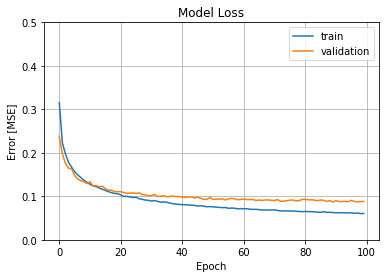

In [ ]:
model_with_dropout = create_model_dropout(x_train.shape[1]) # TYPE
history = model_with_dropout.fit(x_train, y_train, epochs=100, verbose=1, batch_size=2000, validation_split=0.2) # COPY, change to model_with_dropout

plt.plot(history.history['loss']) # COPY
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MSE]')
plt.ylim([0, 0.5])
plt.legend(['train', 'validation'])
plt.grid(True)
plt.show()

Our model trains really smoothly, and seems to not overfit anymore, as the validation loss is always decreasing. If you're satisfied with the performance of your model, you can now see how well it does on the test set:

In [ ]:
predictions = model_with_dropout.predict(x_test)

rel_error = (np.mean(np.abs(predictions - y_test))/np.mean(np.abs(y_test)))
rel_accuracy = 1-rel_error
rel_accuracy

0.753338947892189

So our model does pretty well. It's not the absolute best, we could tweak it a little bit more to get a better accuracy if we wanted to, for example by training for longer, but we won't do that for now.

Now that we are satisfied with our model, we can save our parameters:

In [ ]:
model_with_dropout.save(r'/content/gdrive/MyDrive/my_model')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/my_model/assets


Wherever we are, we can load our model back up without having to rerun everything:

In [ ]:
import tensorflow as tf

reconstructed_model = tf.keras.models.load_model(r'/content/gdrive/MyDrive/my_model')

predictions = reconstructed_model.predict(x_test)
rel_error = (np.mean(np.abs(predictions - y_test))/np.mean(np.abs(y_test)))
rel_accuracy = 1-rel_error
rel_accuracy